# Slice Sampling
Another MCMC method besides Metropolis-Hastings and Gibbs Sampling, Slice Sampling generates random samples based on their previous states. Those samples could then be used to compute integrals (mean, median, etc) or just to plot the histogram, like I'll do here.

Compared to M-H and Gibbs Sampling, Slice Sampling doesn't need any helper distribution. Whereas M-H needs us to pick a proposal distribution `Q(x -> x')`, and Gibbs Sampling needs us to find full conditionals of the joint distribution analytically, Slice Sampling will only need us to provide the target distribution.

For a special case of Slice Sampling where target distribution `P(x)` is unimodal, if we could get our hand to the inverse function of the PDF, implementing Slice Sampling will be a breeze. This post will only cover this special case as it's the simplest.

Let's say we have a Standard Normal from which we want to sample with Slice Sampling. Because Gaussian is unimodal, and the inverse PDF could be easily found analytically, it fits this special case.

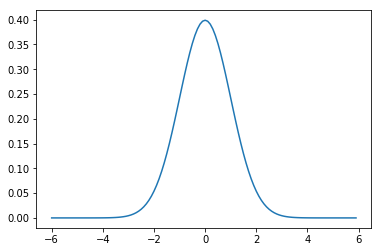

In [6]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

def p(x):
    return st.norm.pdf(x, loc = 0, scale = 1)

x = np.arange(-6, 6, 0.1)
plt.plot(x, p(x))
plt.show()

The equation for the Standard Normal is:

\begin{equation}
P(x) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{x^2}{2}}
\end{equation}

The inverse of this equation is:

\begin{equation}
P^{-1}(y) = \sqrt{-2ln(y \sqrt{2 \pi})}
\end{equation}

The PDF and inverse PDF of Standard Normal is as follows in Python code:

In [8]:
def p(x):
    return np.exp(-(x**2) / 2) / np.sqrt(2*np.pi)

def p_inv(y):
    return np.sqrt(-2 * np.log(y * np.sqrt(2*np.pi)))

Here's the inverse PDF of that Gaussian:

C:\Users\ivani\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


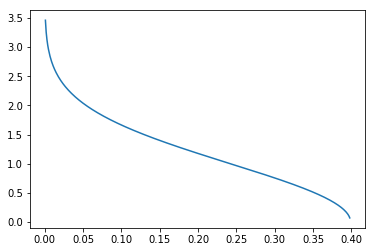

In [25]:
y = np.arange(0.001, 0.4, 0.001)
plt.plot(y, p_inv(y))
plt.show()

Why do we need the inverse PDF? Recall that if we have `y = f(x)`, then if we have y, we could find the x using the inverse function: `x = f_inv(y)`. To give you some visualization, consider a Gaussian. The PDF will give you probability `P(x)` when you feed it with some `x`. Now what happend if we want to know, which `x` would yield this probability `P(x)`? That's where the inverse function comes in. Similarly, think about the relation of CDF and Quantile Function of probability distribution. Quantile Function is an inverse of CDF. Given an `x`, CDF will give you cumulative probability up to `x`. Given a cumulative probability `c`, Quantile Function will give you the `x` such that the cumulative probability at point `x` is `c`.

Here's the algorithm for Standard Normal case (mu = 0, sigma = 1):
1. Set a starting point `x`
2. Sample the height `u ~ Unif(0, p(x))`
3. Sample the next `x ~ Unif(-z, z)` where `z` is the inverse PDF evaluated at `u`
4. Go to step 2

As you can see right away, this is MCMC indeed, as to get the next sample of `x` depends on auxiliary variable `u`, which in turn depends on the current sample of `x`.

Intuitively, let's say our starting point is `x = 0`. Then the Slice Sample will sample a height at that point uniformly from 0 up to the height of the true distribution, or a function that's proportional to the true distribution. That means the sampler will sample `u ~ Unif(0, 0.4)`. Now let's say `u` is 0.25, we then use our inverse PDF to find z, which is x at the right boundary of the curve, which is 1. The inverse function of Gaussian is the right half of that Gaussian. If we're sampling uniformly from `[-z, z]: x ~ Unif(-z, z)`, because Gaussian is symmetric, then it means that we're sampling the line segment that's slicing the area under the curve at height `u`. Using the new `x`, we proceed to find the new `u`, and so on, rinse and repeat until we get the number of samples we want.

The example above is for Standard Normal, the special case of Gaussian. If we want to generalize the Slice Sampler, then we need to do some modification. First, we need to derive the generalized inverse Gaussian PDF, which means we need to take parameter mu and sigma into account when inversing the PDF. Second, we need to take into account the mu when finding the line segment. mu in Gaussian is used to shift the center of the distribution. Because in Standard Normal the mu is 0, we could leave that out. But for general Gaussian, the range of the line segment under the curve at height u would be `[mu-z, mu+z]`.

Let's see that in the code. Here, I picked an arbitrary parameter for the Gaussian, `mu = 65` and `sigma = 32`.

In [27]:
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

mu = 65
sigma = 32

def p(x):
    return st.norm.pdf(x, loc = mu, scale = sigma)

def p_inv(y):
    x = np.sqrt(-2*sigma**2 * np.log(y * sigma * np.sqrt(2*np.pi)))
    return mu-x, mu+x

def slice_sampling(iter = 1000):
    samples = np.zeros(iter)
    x = 0
    
    for i in range(iter):
        u = np.random.uniform(0, p(x))
        x_lo, x_hi = p_inv(u)
        x = np.random.uniform(x_lo, x_hi)
        samples[i] = x
        
    return samples

Here's the sampling result. The green curve is the real PDF of `Normal(65, 32)`.

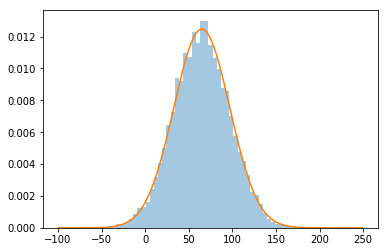

In [31]:
samples = slice_sampling(iter = 10000)
sns.distplot(samples, kde = False, norm_hist = True)
x = np.arange(-100, 250)
plt.plot(x, p(x))
plt.show()

Slice Sampling, being an MCMC, obviously shares some characteristics with the other MCMC methods like Metropolis-Hastings or Gibbs Sampling. Because it's Markovian, there is a correlation between samples, which makes the samples not i.i.d. (Independent and Identically Distributed). To remedy that, we could use a technique called thinning, using only every n<sup>th</sup> samples. Another thing we should do is to let the sampling algorithm run for a little while before collecting samples, to make sure we get only samples we care about. This is called the burn-in period.

The advantage of Slice Sampling compared to M-H and Gibbs Sampling of course is that we don't need to derive or pick anything other than a function that is proportional to the true distribution. However, the implementation of generalized Slice Sampling is rather complicated because we have to consider a lot more cases like when the distribution is multimodal, etc. The hardest part would be to find the line segment under the curve at height u. The special case on unimodal distribution makes finding the line segment really easy.

In this post, we only evaluated Slice Sampling for one dimensional distribution. To sample from multidimensional distribution, we could use Slice Sampling like Gibbs Sampling: run the sampler in turn for each dimension.